# Survival Analysis On Synthesis Data for Diabetic Patients

### Project Details

This is the BYOP (bring your own project) Capstone Project for our IPBA Program from IIM Indore.

### Scope of the Project

This project aims to analyze daibetes patient's TIME ON THERAPY using advance analysis techniques.

### Objective

Main objective for this project is to provide a solution that busineses can implement to understand the patient's behaviour and different scenarios.

### Data

We have generated the simulated Anonymised Patient Level Data using the python Faker module.

| Field                     | Description                                                                   |
|:--------------------------|:------------------------------------------------------------------------------|
|: claim_id                :|: Insurance Claim Number (Unique)                                             :|
|: patient_id              :|: Patient Unique ID                                                           :|
|: service_date            :|: Date when the claim was initiated                                           :|
|: claim_type              :|: Paid, Rejected or Reversed Claim                                            :|
|: days_supply             :|: No. of Days Drugs was Supplied For                                          :|
|: quantity                :|: Quantity of Medicine(Capsules)                                              :|
|: patient_birth_year      :|: DOB of Patient                                                              :|
|: gender                  :|: Gender of Patient                                                           :|
|: diseases_type           :|: T1: Type 1 / T2: Type 2 Diabetes                                            :|
|: ndc                     :|: Product ID / Unique Durg Code                                               :|
|: drug_name               :|: Brand Name of the Drug                                                      :|
|: class                   :|: Category of Drug                                                            :|
|: sub_class               :|: Sub Category of Drug                                                        :|
|: mode_of_dispensation    :|: How drug is Dispensed - Oral or Injectible                                  :|
|: treatment_hierarchy     :|: The order in which drug is prescribed as diabetes intensifies               :|
|: past_medical_history    :|: Yes or No                                                                   :|
|: family_history          :|: Family History of Diabetes - Yes or No                                      :|
|: is_there_complication   :|: Yes or No                                                                   :|
|: marital_status          :|: Married or Unmarried                                                        :|
|: educational_status      :|: Educated or Uneducated                                                      :|
|: employee_status         :|: Employed or Unemployed                                             :|

# Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lifelines
import os
import pymysql.cursors
import warnings
warnings.filterwarnings('ignore')   # ignore warnings
from datetime import datetime
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter
from lifelines.utils import median_survival_times
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split    # split data

In [3]:
# Filters
start_date = '2019-01-01'
end_date = '2022-12-31'

# Import Data

In [4]:
apld_df = pd.read_pickle('df_diabetes_s1.pickle')

In [5]:
apld_df.head().T

,0,1,2,3,4
claim_id,517566340,387782725,999807010,999807011,999807012
patient_id,20006,20006,20006,20006,20006
service_date,2021-10-30,2021-12-14,2022-02-12,2022-05-13,2022-05-13
claim_type,pd,pd,pd,pd,pd
days_supply,45,60,90,45,45
quantity,60,15,75,75,75
patient_birth_year,1963,1963,1963,1963,1963
gender,m,m,m,m,m
disease_type,t2,t2,t2,t2,t2
ndc,47152818127,83161652750,83161652750,83903911733,78589353539


### Filtering Relevant Data

Data Satisfying the following conditions
```
- Paid claims
- For Patients with Type 2 Diabetes
- Within Study Date Range
```

In [6]:
apld = apld_df[apld_df['claim_type'].isin(['pd'])].copy()
apld['service_date'] = pd.to_datetime(apld['service_date'])

# Type 2 Diabetes

apld = apld[apld['disease_type'].isin(['t2'])]

apld = apld[apld['service_date'].between(start_date, end_date)]

# Feature Creation

- `tot`           : time on therapy (first day supply till last day supply)
- `survived`      : whether the patient is active or not by the end of our study
- `total_time`    : time period of the study - 4 years
- `dc`            : days covered (sum(days_supply))

### Calculate Patients Age

In [7]:
# Take max birth date, as some patients have multiple birth dates
age_df = apld.groupby('patient_id').agg({'patient_birth_year': 'max'}).reset_index()
now = datetime.now()
age_df['age'] = now.year - age_df['patient_birth_year']

### Derive tot (Time on Therapy)

In [8]:
apld['drug_supply_next_date'] = apld['service_date'] + pd.to_timedelta(apld['days_supply'], unit='d')

In [9]:
tot = apld.groupby('patient_id').agg({'service_date': 'min', 'drug_supply_next_date': 'max'}).reset_index().rename(columns={'service_date': 'drug_supply_first_date', 'drug_supply_next_date': 'drug_supply_last_date'})

In [11]:
# Duplicates
tot['dup'] = tot.duplicated('patient_id', keep=False)
print(tot['dup'].value_counts())
del tot['dup']

False    9027
Name: dup, dtype: int64


In [13]:
# Deriving tot
tot['tot'] = (tot['drug_supply_last_date'] - tot['drug_supply_first_date']).dt.days
tot['total_time'] = (pd.Timestamp(end_date) - pd.Timestamp(start_date)).days

### Survival Assumption

Our Assumption is that if a patient does not take medication after the last date date of drug supply expired then the patients has `DISCONTINUED TREATMENT`. We see that in the study period (2019 to 2022) ~76% patients have discontinued or not stayed on the therapy for the complete period of the study.

In [14]:
tot['survived'] = np.where(tot['drug_supply_last_date'] <= end_date, '1', '0')

In [15]:
tot['survived'].value_counts()

1    6896
0    2131
Name: survived, dtype: int64

In [16]:
# Normalised tot
tot['survived'].value_counts(normalize=True)

1    0.76393
0    0.23607
Name: survived, dtype: float64

### Plot of overall survived

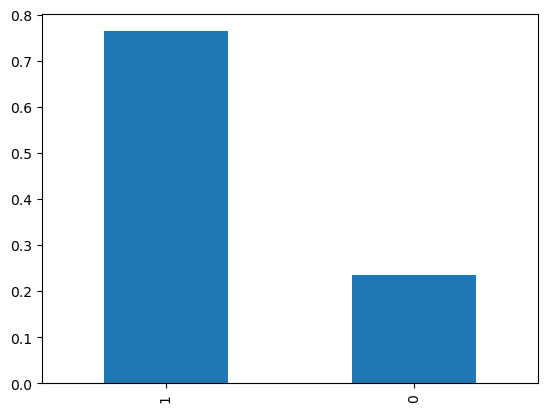

In [18]:
tot['survived'].value_counts(normalize=True).plot(kind='bar')
plt.show()

## Derive Days Covered

In [20]:
# Days Covered
dc = apld.groupby('patient_id').agg({'days_supply': 'sum'}).reset_index().rename(columns={'days_supply': 'dc'})

In [21]:
# Combine tot and dc
apld = pd.merge(apld, tot[['patient_id', 'drug_supply_first_date', 'drug_supply_last_date', 'tot', 'total_time', 'survived']], on=['patient_id'], how='left')
apld = pd.merge(apld, dc, on=['patient_id'], how='left')
apld = pd.merge(apld, age_df[['patient_id', 'age']], on=['patient_id'], how='left')